In [1]:
# Author and date
import datetime, getpass
print(getpass.getuser(), datetime.datetime.today())

dimitri 2019-09-22 19:01:49.311674


# Attachments and configurable blobs (new in datajoint 0.12.0)

This notebooks demonstrates the storage and retrieval of complex datatypes (blobs) and file attachments in DataJoint.

A **blob** refers to an attribute in a table that can store complex data structures such as numeric arrays.

An **attachment** refers to an attribute that can store an entire file with its filename, etc.

Both blobs and attachments can be stored directly in the tables of the relational database or in configurable external "stores" such as network-attached storage servers or object storage systems such [Amazon S3](https://aws.amazon.com/s3/) and [Minio](https://min.io/).

Many of these features existing in prior releases of datajoint but have been substantially expanded in version 0.12.0.

In [2]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import os
import imageio
import requests
from ipywidgets import Image
import ipywidgets
import numpy as np

import datajoint as dj

In [3]:
dj.__version__

'0.12.dev7'

## Configure stores
The following is a configuration defining two external stores. This should only be done once for all users and the configuration file must be saved and provided to all users.

The first store is named `"shared"` and is hosted on an S3 endpoint. 

The second store is named `"local"` and it uses the local path `./dj-store`.

Now these repositories can be used for blobs and attachments.

In [4]:
## Storage configuration

# set up stores
dj.config['stores'] = {
    'shared': dict(
        protocol='s3',
        endpoint='localhost:9000',
        access_key='datajoint',
        secret_key='datajoint',
        bucket='datajoint-demo',        
        location=''
    ),       
    'local': {  # store in files
        'protocol': 'file',
        'location': os.path.abspath('./dj-store')
    }}

In [6]:
schema.drop()  # drop if exists to create anew

Proceed to delete entire schema `test_attach`? [yes, No]: yes


In [7]:
# create a schema for this demo
schema = dj.schema('test_attach')

# A Minimal example of blobs and configurable blobs
Let's declear the table Test with blobs and attachments stored intrnally and externally.

In [8]:
@schema
class Test(dj.Manual):
    definition = """
    # Test blob and attachments
    id : int
    ---
    b0 : longblob       # a python object stored internally in the table
    b1 : blob@shared    # a python object stored on S3
    b2 : blob@local     # a python object store on the file system
    a0 : attach         # a file attachment stored internally in the table
    a1 : attach@shared  # a file attachment stored on s3
    a2 : attach@local   # a file attachment stored on the file system
    """

In [9]:
# Create three numpy arrays as save them in different files
q0, q1, q2 = np.random.randn(3,4), np.random.randn(7), np.random.randn(2, 3, 4)
f0, f1, f2 = './outfile0.npy', './outfile1.npy', './outfile2.npy'
np.save(f0, q0)
np.save(f1, q1)
np.save(f2, q2)

In [10]:
Test.delete()

About to delete:
Nothing to delete


In [11]:
# insert the blobs and the attachments into the table
Test.insert1(dict(id=1, b0=q0, b1=q1, b2=q2, a0=f0, a1=f1, a2=f2))

In [12]:
Test()

id,b0 a python object stored internally in the table,b1 a python object stored on S3,b2 a python object store on the file system,a0 a file attachment stored internally in the table,a1 a file attachment stored on s3,a2 a file attachment stored on the file system
1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [13]:
# delete the attached files
os.remove(f0)
os.remove(f1)
os.remove(f2)

In [14]:
# now fetch them and verify that they retrieved correctly
result = Test.fetch(as_dict=True)

In [15]:
result[0]['b0']

array([[-0.85035043,  0.51232597,  0.5565862 ,  0.67085516],
       [ 0.4474043 , -0.96364731,  2.43882203, -0.0653516 ],
       [-0.12736482, -0.13280121, -1.55808291,  0.44561754]])

In [16]:
q0

array([[-0.85035043,  0.51232597,  0.5565862 ,  0.67085516],
       [ 0.4474043 , -0.96364731,  2.43882203, -0.0653516 ],
       [-0.12736482, -0.13280121, -1.55808291,  0.44561754]])

In [17]:
np.array_equal(q0, result[0]['b0'])

True

In [18]:
result[0]['a1']

PosixPath('outfile1.npy')

In [19]:
np.load(result[0]['a1'])

array([ 0.46075428, -0.71541006,  0.11481679, -0.83345537, -0.62449367,
        0.07225138, -0.92294531])

In [20]:
q1

array([ 0.46075428, -0.71541006,  0.11481679, -0.83345537, -0.62449367,
        0.07225138, -0.92294531])

In [21]:
schema.external

External file tables for schema `test_attach`:
    "shared" s3:
    "local" file:/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store

In [22]:
schema.external['local']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
a774fa61-c1b0-3ff6-a286-42bbcab0dccb,237,None,None,None,2019-09-23 00:02:02
dbb73839-9410-a560-cdd9-96d60511995f,320,outfile2.npy,None,None,2019-09-23 00:02:02


In [23]:
schema.external['shared']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
16f1835d-23c8-5391-d747-7b808bd6a9a7,184,outfile1.npy,None,None,2019-09-23 00:02:02
9e814d10-39bb-3fd4-30a6-5cb88c49c282,85,None,None,None,2019-09-23 00:02:02


In [24]:
schema.external['local'].fetch_external_paths()

[(UUID('a774fa61-c1b0-3ff6-a286-42bbcab0dccb'),
  PurePosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store/test_attach/a7/74/a774fa61c1b03ff6a28642bbcab0dccb')),
 (UUID('dbb73839-9410-a560-cdd9-96d60511995f'),
  PurePosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store/test_attach/db/b7/dbb738399410a560cdd996d60511995f.outfile2.npy'))]

In [25]:
schema.external['shared'].fetch_external_paths()

[(UUID('16f1835d-23c8-5391-d747-7b808bd6a9a7'),
  PurePosixPath('test_attach/16/f1/16f1835d23c85391d7477b808bd6a9a7.outfile1.npy')),
 (UUID('9e814d10-39bb-3fd4-30a6-5cb88c49c282'),
  PurePosixPath('test_attach/9e/81/9e814d1039bb3fd430a65cb88c49c282'))]

In [26]:
schema.external['shared'].used()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
16f1835d-23c8-5391-d747-7b808bd6a9a7,184,outfile1.npy,None,None,2019-09-23 00:02:02
9e814d10-39bb-3fd4-30a6-5cb88c49c282,85,None,None,None,2019-09-23 00:02:02


In [27]:
schema.external['local'].used()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
a774fa61-c1b0-3ff6-a286-42bbcab0dccb,237,None,None,None,2019-09-23 00:02:02
dbb73839-9410-a560-cdd9-96d60511995f,320,outfile2.npy,None,None,2019-09-23 00:02:02


In [28]:
schema.external['shared'].unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp


In [29]:
Test.delete()

About to delete:
`test_attach`.`test`: 1 items
Proceed? [yes, No]: yes
Committed.


In [30]:
schema.external['shared']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
16f1835d-23c8-5391-d747-7b808bd6a9a7,184,outfile1.npy,None,None,2019-09-23 00:02:02
9e814d10-39bb-3fd4-30a6-5cb88c49c282,85,None,None,None,2019-09-23 00:02:02


In [31]:
schema.external['shared'].delete(delete_external_files=True)

100%|██████████| 2/2 [00:00<00:00, 63.44it/s]


[]

In [32]:
# complete cleanup of all external stores
for s in schema.external.values():
    s.delete(delete_external_files=True)

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 71.77it/s]


## Lookup of images on the web
We create a lookup table, WebImage to point to some images available on the web

In [33]:
@schema
class WebImage(dj.Lookup):
    definition = """
    # A reference to a web image
    image_number : int
    ---
    image_name : varchar(30)
    image_description : varchar(1024)
    image_url : varchar(1024)
    
    unique index(image_name)
    """
    contents = [
        (0, "pyramidal", 
         
         'Coronal section containing the chronically imaged pyramidal neuron "dow" '\
         '(visualized by green GFP) does not stain for GABA (visualized by antibody staining in red). '\
         'Confocal image stack, overlay of GFP and GABA channels. Scale bar: 100 um',
         
         "https://upload.wikimedia.org/wikipedia/commons/d/dc/PLoSBiol4.e126.Fig6fNeuron.jpg"
        ),
        (1, "striatal", 
         
         "Mouse spiny striatal projection neuron expressing a transgenic fluorescent protein "\
         "(colored yellow) delivered by a recombinant virus (AAV). "\
         "The striatal interneuron are stainerd in green for the neurokinin-1 receptor.",
         
         "https://upload.wikimedia.org/wikipedia/commons/e/e8/Striatal_neuron_in_an_interneuron_cage.jpg"
        )
    ]

### Preview the images directly from the web

In [34]:
Image.from_url((WebImage & 'image_number=0').fetch1('image_url'))

Image(value=b'https://upload.wikimedia.org/wikipedia/commons/d/dc/PLoSBiol4.e126.Fig6fNeuron.jpg', format='url…

In [35]:
Image.from_url((WebImage & 'image_number=1').fetch1('image_url'))

Image(value=b'https://upload.wikimedia.org/wikipedia/commons/e/e8/Striatal_neuron_in_an_interneuron_cage.jpg',…

## Define a table with attachments
Now we can use the stores to define attachment attributes in the form `attribute_name : attach@store  # comment` where the store is either `@local` or `@shared` as defined above.

Let's define the table `OriginalFile` to automatically download and attach files from `WebImage` and stores the attachments in the shared store.

In [36]:
@schema
class OriginalFile(dj.Imported):
    definition = """
    -> WebImage
    ---
    image_file : attach@shared
    """
    
    def make(self, key):
        # get the URL
        url = (WebImage & key).fetch1('image_url')
        
        # download the file from the web
        local_file = os.path.join(os.path.abspath('.'), url.split('/')[-1])
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
            
        # attach the file
        self.insert1(dict(key, image_file=local_file))
        
        # delete the downloaded file
        os.remove(local_file)

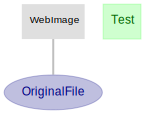

In [37]:
dj.Diagram(schema)

In [38]:
# perform the download
OriginalFile.populate()

In [39]:
OriginalFile()

image_number,image_file
0,=BLOB=
1,=BLOB=


In [40]:
# preview downloaded attachment
file = (OriginalFile & 'image_number=1').fetch1('image_file')
Image.from_file(file)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\…

In [41]:
os.remove(file)

## Extract images into blobs
Now let's define another class that extracts imags from attached files and stores as blobs in the local store.

In [42]:
# Declare a table with a configurable blob
@schema
class Slide(dj.Computed):
    definition = """
    -> OriginalFile
    ---
    image_array : blob@local  # array in specified store
    """
    
    def make(self, key):
        # get the attached file
        file = (OriginalFile & key).fetch1('image_file')
        
        # save image data
        self.insert1(dict(key, image_array=imageio.imread(file)))
        
        # remove the downloaded file
        os.remove(file)

In [43]:
Slide.populate()

In [44]:
Slide()

image_number,image_array array in specified store
1,=BLOB=
0,=BLOB=


In [45]:
schema.external

External file tables for schema `test_attach`:
    "shared" s3:
    "local" file:/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store

In [46]:
schema.external['local']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
403b8717-6c83-fa52-d381-e1371e61e4ac,1324311,None,None,None,2019-09-23 00:03:05
cbc9f232-6abd-6863-c449-9cb82a11e47a,1707130,None,None,None,2019-09-23 00:03:05


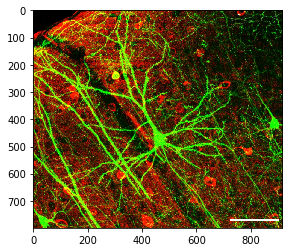

In [47]:
# Plot image form a blob
plt.imshow((Slide & 'image_number=0').fetch1('image_array'));

## Caching
By default, the data from blobs and attachments are retrieved from remote stores with every fetch command. 
For repeated queries, a cache folder may be specified to improve performance and reduce cost of operations.
After the first fetch of a given blob or attachment, it will be read from the cache. 

In [48]:
# configure the cache
dj.config['cache'] = './dj-cache'

In [49]:
# clear the cache for the timing test
import shutil
if os.path.isdir(dj.config['cache']):
    shutil.rmtree(dj.config['cache'])

In [50]:
%%timeit -n1 -r1

# first time no cache
files = OriginalFile.fetch('image_file')

22.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
%%timeit -n1 -r1

# now with cache
files = OriginalFile.fetch('image_file')

14.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Deleting
Deleting from tables using external storage is just as simple and transaction-safe as with all other kinds of attributes. Simply use the `delete` method:

In [52]:
schema.external

External file tables for schema `test_attach`:
    "shared" s3:
    "local" file:/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store

In [53]:
schema.external['shared']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
00bffedc-d5c2-f928-f0d5-4d31fe01311d,806133,PLoSBiol4.e126.Fig6fNeuron.jpg,None,None,2019-09-23 00:02:58
81c1c2d3-3c08-66ed-1d64-c96376539195,895051,Striatal_neuron_in_an_interneuron_cage.jpg,None,None,2019-09-23 00:02:58


In [54]:
schema.external['shared'].unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp


In [55]:
(WebImage & 'image_number=0').delete()

About to delete:
`test_attach`.`__slide`: 1 items
`test_attach`.`_original_file`: 1 items
`test_attach`.`#web_image`: 1 items
Proceed? [yes, No]: yes
Committed.


In [56]:
schema.external['shared'].unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
00bffedc-d5c2-f928-f0d5-4d31fe01311d,806133,PLoSBiol4.e126.Fig6fNeuron.jpg,None,None,2019-09-23 00:02:58


# Deleting

For the sake of performance, deleting from the data tables does not remove the data from external storage. 

The `delete` method of the external table deletes its **unused** entries and their corresponding external files.

In [57]:
schema.external

External file tables for schema `test_attach`:
    "shared" s3:
    "local" file:/home/dimitri/dev/db-programming-with-datajoint/notebooks/dj-store

You may cleanup the external table using its `delete` method.  It is a transaction-safe operation and can be performed at any time.

In [58]:
schema.external['local'].delete(delete_external_files=True)

100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


[]

In [59]:
schema.external['shared'].delete(delete_external_files=True)

100%|██████████| 1/1 [00:00<00:00, 57.82it/s]


[]

In [60]:
for s in schema.external.values():
    s.delete(delete_external_files=True)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [61]:
schema.external['shared'].used()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
81c1c2d3-3c08-66ed-1d64-c96376539195,895051,Striatal_neuron_in_an_interneuron_cage.jpg,None,None,2019-09-23 00:02:58


In [62]:
schema.external['shared'].unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
